In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import tft2d
import timm
from types import SimpleNamespace
from torchvision.transforms.v2 import (
    Compose, Resize, CenterCrop,
    PILToTensor, ToPILImage)
from datasets import load_dataset
from fastprogress.fastprogress import progress_bar

In [62]:
device = 'cpu'
config = SimpleNamespace()
config.batch_size = 1
config.num_workers = 12
config.image_size = 288
config.crop_size = 256
config.channels = 3

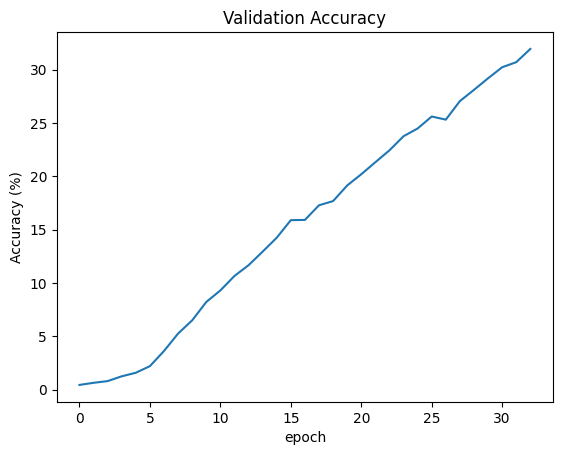

<All keys matched successfully>

In [63]:
checkpoint = torch.load("output/train/20241220-120937-tft2d-256/model_best.pth.tar",map_location='cpu',weights_only=False)
data = pd.read_csv('output/train/20241220-120937-tft2d-256/summary.csv')
data.plot(x='epoch', y='eval_top1', legend=False, title='Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.show()

model = timm.create_model('tft2d')
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
dataset_valid = load_dataset('danjacobellis/imagenet_288_webp',split='validation')

README.md:   0%|          | 0.00/702 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00000-of-00066.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

train-00001-of-00066.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

train-00002-of-00066.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00003-of-00066.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

train-00004-of-00066.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

train-00005-of-00066.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00006-of-00066.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

In [65]:
cent_crop = Compose([
    CenterCrop(size=config.crop_size),
    PILToTensor()
])

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['webp'])
    return (x,y)

In [ ]:
n_correct = 0 
data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)
pb_valid = progress_bar(data_loader_valid)
for i_batch, (x, y) in enumerate(pb_valid):
    y = y.to(torch.long).to(device)
    x = x.to(device).to(torch.float)/255
    with torch.no_grad():
        logits = model(x-0.5)
    n_correct += torch.sum(logits.argmax(dim=1) == y).item()

mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'